In [ ]:
# mount git hub repo
!git clone https://github.com/gamma-opt/icnn.git


Cloning into 'icnn'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 29 (delta 12), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (29/29), 117.99 KiB | 5.36 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
# install julia
%%shell
set -e
wget -nv https://raw.githubusercontent.com/joaquimg/SBPO2024/main/install_colab.sh -O /tmp/install_colab.sh
bash /tmp/install_colab.sh  # Takes ~ 2 minutes

2024-11-21 14:52:17 URL:https://raw.githubusercontent.com/joaquimg/SBPO2024/main/install_colab.sh [1058/1058] -> "/tmp/install_colab.sh" [1]
Installing Julia 1.10.5 on the current Colab Runtime...
2024-11-21 14:52:19 URL:https://julialang-s3.julialang.org/bin/linux/x64/1.10/julia-1.10.5-linux-x86_64.tar.gz [173909866/173909866] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.10


Now,
- go to the "Runtime" tab
- select "Change runtime type"
- select julia in the "Runtime type" dropdown
- click "save"

You might need to refresh the page.


In [4]:
import Pkg
Pkg.add("Gogeta")
Pkg.add("JuMP")
Pkg.add("Plots")
Pkg.add("JSON")
Pkg.add("Alpine")
Pkg.add("HiGHS")
Pkg.add("Juniper")
Pkg.add("Ipopt")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed GPUArraysCore ─────────────── v0.1.6
   Installed RealDot ───────────────────── v0.1.0
   Installed IrrationalConstants ───────── v0.2.2
   Installed IRTools ───────────────────── v0.4.14
   Installed MutableArithmetics ────────── v1.6.0
   Installed Transducers ───────────────── v0.4.84
   Installed ScientificTypesBase ───────── v3.0.0
   Installed DiffRules ─────────────────── v1.15.1
   Installed Adapt ─────────────────────── v4.1.1
   Installed Rmath ─────────────────────── v0.8.0
   Installed ShowCases ─────────────────── v0.1.0
   Installed Functors ──────────────────── v0.4.12
   Installed ContextVariablesX ─────────── v0.1.3
   Installed HypergeometricFunctions ───── v0.3.25
   Installed Flux ──────────────────────── v0.14.25
   Installed ArgCheck ──────────────────── v2.3.0
   Installed FLoopsBase ────────────────── v0.1.1
   Installed PtrArrays ─────────────────── v1.2.1


In [89]:
using Gogeta
using JuMP
using Plots
using JSON
using Alpine
using HiGHS
using Juniper
using Ipopt

# replace with the path to the model_weights.json file
filepath = "icnn/model_weights_3D.json"

# Read the JSON file
json_content = read(filepath, String)

# Parse the JSON content
parsed_json = JSON.parse(json_content)

Dict{String, Any} with 3 entries:
  "FC2"   => Any[Any[Any[1.03549], Any[1.30402], Any[0.900177], Any[-0.986264]], Any[-0.120368]]
  "SKIP2" => Any[Any[Any[-0.0569543], Any[-0.963749]]]
  "FC1"   => Any[Any[Any[-1.25098, 0.0175221, 1.4946, 0.0201405], Any[-0.00281553, 1.53142, -0.0232…

In [90]:
#-----------------------------ICNN-------------------------------------------------#

# Configure Ipopt to be silent
nlp_solver = optimizer_with_attributes(
    Ipopt.Optimizer,
    "print_level" => 0
)

# Configure Juniper to be silent
juniper_solver = optimizer_with_attributes(
    Juniper.Optimizer,
    "nl_solver" => nlp_solver,
    "log_levels" => []
)

# Configure HiGHS to be silent
milp_solver = optimizer_with_attributes(
    HiGHS.Optimizer,
    "output_flag" => false
)

# Create the Alpine optimizer with silent logging
alpine_optimizer = optimizer_with_attributes(
    Alpine.Optimizer,
    "nlp_solver" => juniper_solver,
    "mip_solver" => milp_solver,
    "log_level" => 0  # Ensure Alpine's logging is silent
)

# define the icnn model
icnn_lp =  Model(alpine_optimizer)

# define the output variable
icnn_output_var = @variable(icnn_lp, z, base_name="output_var")

# define the input variable
icnn_input_var_1 = @variable(icnn_lp, x1, base_name="input_var_1")

# define the input variable
icnn_input_var_2 = @variable(icnn_lp, x2, base_name="input_var_2")

# define the objective function
@objective(icnn_lp, Min, 0)

# define the constraints on input variable
@constraint(icnn_lp, x1 <= 1)
@constraint(icnn_lp, x1 >= -1)
# define the constraints on input variable
@constraint(icnn_lp, x2 <= 1)
@constraint(icnn_lp, x2 >= -1)


# add variables, constraints, and an objective function to the icnn_lp model to account for the generated ICNN.
ICNN_incorporate!(icnn_lp, filepath, icnn_output_var, icnn_input_var_1, icnn_input_var_2)

function forwardpass(jump_model, input_values)
    fix(icnn_lp[:x1], input_values[1]; force = true)
    fix(icnn_lp[:x2], input_values[2]; force = true)
    optimize!(jump_model)
    return value.(jump_model[:z])
end



forwardpass (generic function with 1 method)

In [91]:
#---------------------------Out ICNN-----------------------------------------------#
# define the outter jump model
out_icnn_lp = Model(alpine_optimizer)

# define the output variable
out_output_var = @variable(out_icnn_lp, z, base_name="output_var")

# define the input variable
out_input_var_1 = @variable( out_icnn_lp, x1, base_name="input_var_1")

# define the input variable
out_input_var_2 = @variable( out_icnn_lp, x2, base_name="input_var_2")


# define the objective
@objective(out_icnn_lp, Min, 0)

# define the constraints on input variable
@constraint(out_icnn_lp, x1 <= 1)
@constraint(out_icnn_lp, x1 >= -1)
# define the constraints on input variable
@constraint(out_icnn_lp, x2 <= 1)
@constraint(out_icnn_lp, x2 >= -1)



input_var_2 ≥ -1

In [95]:
#---------------------------Example 1----------------------------------------------#

# add contraint on the output variable
#@constraint(out_icnn_lp, exm_1, z >= 0.5)

# define the objective
@objective(out_icnn_lp, Min, 0)

# add variables, constraints, and an objective function to the out_icnn_lp model to account for the generated ICNN.
ICNN_incorporate!(out_icnn_lp, filepath, out_output_var, out_input_var_1, out_input_var_2)

# optimize the outter jump model
optimize!(out_icnn_lp)

# save the input and output values
x1_optimal = value.(out_icnn_lp[:x1])
x2_optimal = value.(out_icnn_lp[:x2])
out_z_optimal = value.(out_icnn_lp[:z])

icnn_z_optimal = forwardpass(icnn_lp, [x1_optimal, x2_optimal])

# Define the function f(x) = x1^2+x2^2
f(x1,x2) = x1^2+x2^2


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***


f (generic function with 2 methods)

In [99]:
println(out_icnn_lp)

Min output_var
Subject to
 -input_var_1 + _[4] = 0
 -input_var_2 + _[5] = 0
 output_var - _[10] = 0
 -input_var_1 + _[11] = 0
 -input_var_2 + _[12] = 0
 output_var - _[17] = 0
 input_var_1 ≥ -1
 input_var_2 ≥ -1
 _[6] ≥ 0
 _[7] ≥ 0
 _[8] ≥ 0
 _[9] ≥ 0
 1.2509831190109253 _[4] + 0.0028155313339084387 _[5] + _[6] ≥ -0.43406370282173157
 -0.01752214878797531 _[4] - 1.5314197540283203 _[5] + _[7] ≥ -0.020403772592544556
 -1.4946047067642212 _[4] + 0.023208295926451683 _[5] + _[8] ≥ -0.459965318441391
 -0.020140498876571655 _[4] + 0.04838086664676666 _[5] + _[9] ≥ -0.06724819540977478
 0.056954313069581985 _[4] + 0.9637486934661865 _[5] - 1.0354883670806885 _[6] - 1.3040201663970947 _[7] - 0.9001766443252563 _[8] + 0.9862638711929321 _[9] + _[10] ≥ -0.12036830186843872
 _[13] ≥ 0
 _[14] ≥ 0
 _[15] ≥ 0
 _[16] ≥ 0
 1.2509831190109253 _[11] + 0.0028155313339084387 _[12] + _[13] ≥ -0.43406370282173157
 -0.01752214878797531 _[11] - 1.5314197540283203 _[12] + _[14] ≥ -0.020403772592544556
 -1.494

In [98]:
# Generate data for plotting
x1_values = -1:0.1:1
x2_values = -1:0.1:1


# Select a backend (optional)
gr()  # You can also use plotlyjs() or pyplot()


# Plot the function in 3D
surface(
    x1_values, x2_values, f,
    xlabel = "x1",
    ylabel = "x2",
    zlabel = "z",
    title = "Plot of z = x₁² + x₂²"
)

#
icnn = zeros(length(x1_values))
for i in 1:length(x1_values)
  icnn[i] = forwardpass(icnn_lp, [x1_values[i] x2_values[i]])
end


forwardpass(icnn_lp, [x1_values[1] x2_values[1]])


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***


-986262.1221309

In [ ]:
#---------------------------Example 2---------------------------------------------#

delete(out_icnn_lp, exm_1)

# define the objective
@objective(out_icnn_lp, Max, x+z)

# add variables, constraints, and an objective function to the out_icnn_lp model to account for the generated ICNN.
ICNN_incorporate!(out_icnn_lp, filepath, out_output_var, out_input_var)

# optimize the outter jump model
optimize!(out_icnn_lp)

# save the input and output values
x_optimal = value.(out_icnn_lp[:x])
out_z_optimal = value.(out_icnn_lp[:z])


*** Alpine ended with status OPTIMAL ***


168055.6667133


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTI

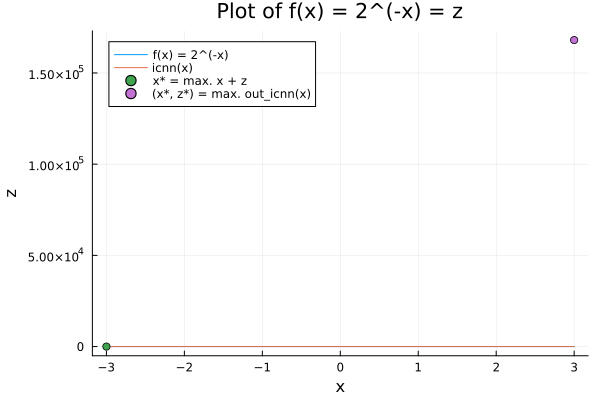

In [ ]:
# Define the function f(x) = 2^(-x)
f(x) = 2^(-x)

# Generate data for plotting
x_values = -3:0.1:3
y_values = f.(x_values)

# Plot the function
plot(x_values, y_values, label="f(x) = 2^(-x)", xlabel="x", ylabel="z", title="Plot of f(x) = 2^(-x) = z")

#forward pass x_values to the icnn model
icnn = forwardpass.(icnn_lp, x_values)
# Plot the function
plot!(x_values, icnn, label="icnn(x)")

# calculate x+z values
xz = x_values .+ icnn

max_ind = findfirst(x -> x == maximum(xz), xz)
scatter!([x_values[max_ind]], [icnn[max_ind]], label="x* = max. x + z")

scatter!([x_optimal], [out_z_optimal], label="(x*, z*) = max. out_icnn(x)")